In [1]:
import matplotlib.pyplot as plt
from transformers import pipeline

bert_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)
state_dict = pipe.model.state_dict()
state_dict.keys()

odict_keys(['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.0.output_layer_norm.

In [2]:
import torch
from torch import quantize_per_tensor

weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
scale = (weights.max() - weights.min()) / 255
zero_point = 0
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)

In [3]:
weights.flatten().numpy()

array([-0.02809844, -0.03987114,  0.00129087, ...,  0.04325824,
        0.01052545, -0.00907145], dtype=float32)

In [4]:
quantized_weights

tensor([[-0.0265, -0.0424,  0.0000,  ..., -0.0318, -0.0212,  0.0424],
        [ 0.0477,  0.0159,  0.0053,  ..., -0.0212,  0.0371,  0.0000],
        [-0.0477, -0.0318,  0.0265,  ...,  0.0000,  0.0318, -0.0159],
        ...,
        [ 0.0265,  0.0000,  0.0636,  ...,  0.0000,  0.0318, -0.0053],
        [ 0.0000, -0.0106, -0.0636,  ...,  0.0583, -0.0424, -0.0689],
        [-0.0689, -0.0053, -0.0477,  ...,  0.0424,  0.0106, -0.0106]],
       size=(768, 768), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.005302110221236944,
       zero_point=0)

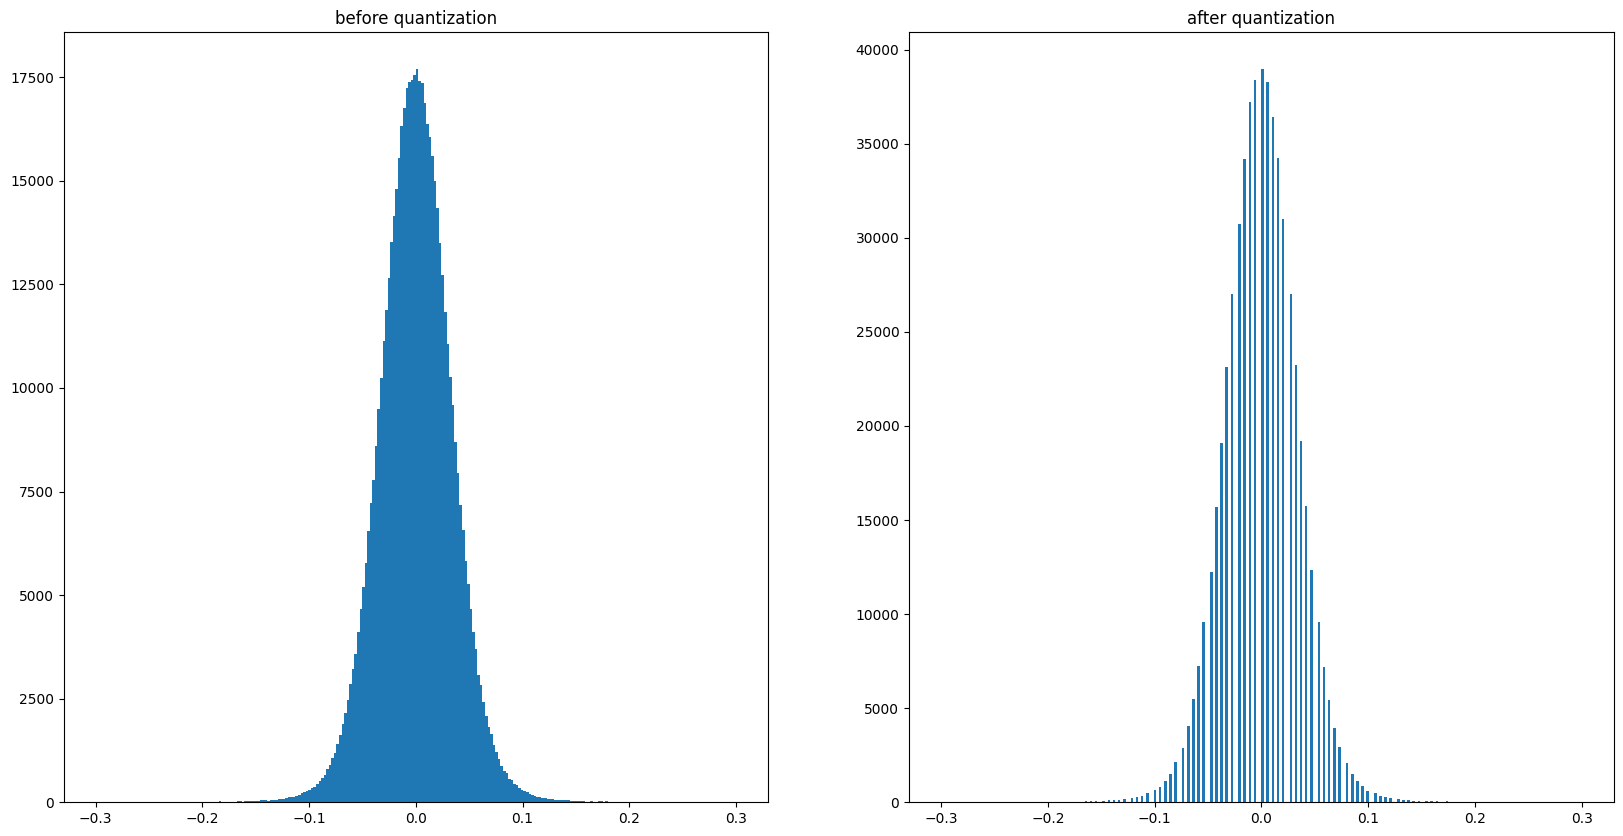

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('before quantization')
ax2.set_title('after quantization')

ax1.hist(weights.flatten().numpy(), bins=250, range=(-0.3, 0.3))
ax2.hist(quantized_weights.flatten().dequantize().numpy(), bins=250, range=(-0.3, 0.3))
# plt.axis('off')
plt.show()

In [6]:
%%timeit -r 10 -n 1000
weights @ weights

1.99 ms ± 281 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [7]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [8]:
%%timeit -r 10 -n 1000
q_fn.mul(quantized_weights, quantized_weights)

154 µs ± 9.35 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [36]:
from torch.quantization import quantize_dynamic
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_ckpt = 'transformersbook/bert-base-uncased-finetuned-clinc'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to('cpu')
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [32]:
from datasets import load_metric
from pathlib import Path
from time import perf_counter
import numpy as np
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")
intents = clinc["test"].features["intent"]
accuracy_score = load_metric("accuracy")

class PerformanceBenchmark :
    def __init__(self, pipeline, dataset, optim_type="BERT baseline") :
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self) :
        preds, labels = [], []
        for example in self.dataset :
            pred = self.pipeline(example["text"])[0]["label"]
            label = example["intent"]
            preds.append(intents.str2int(pred))
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"valid accuracy : {accuracy['accuracy']:.4f}")
        return accuracy
    
    def compute_size(self) :
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        size_mb = Path(tmp_path).stat().st_size / (1024*1024)
        tmp_path.unlink()
        print(f"model size : {size_mb:.4f} MB")
        return {"size_mb": size_mb}
            
    def time_pipeline(self, query="What is the pin number for my account?") :
        latencies = []
        for _ in range(10) :
            _ = self.pipeline(query)
        for _ in range(100) :
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"time avg : {time_avg_ms:.4f} ms +\- {time_std_ms:.4f} ms")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}    
    
    def run_benchmark(self) :
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

Found cached dataset clinc_oos (/root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
# Original
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)
optim_type = "normal"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type)
perf_metrics = pb.run_benchmark()

model size : 418.1508 MB
time avg : 18.6043 ms +\- 0.4324 ms
valid accuracy : 0.8673


In [38]:
# Quantized
pipe = pipeline("text-classification", model=model_quantized, tokenizer=tokenizer)
optim_type = "quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type)
perf_metrics.update(pb.run_benchmark())

model size : 173.1863 MB
time avg : 14.8308 ms +\- 1.2016 ms
valid accuracy : 0.8635


In [39]:
perf_metrics

{'normal': {'size_mb': 418.1508378982544,
  'time_avg_ms': 18.604253362864256,
  'time_std_ms': 0.4323600207423431,
  'accuracy': 0.8672727272727273},
 'quantization': {'size_mb': 173.18634510040283,
  'time_avg_ms': 14.830832919105887,
  'time_std_ms': 1.2016338259314059,
  'accuracy': 0.8634545454545455}}